# Analysis of Austin Animal Center Shelter Outcome dataset
Trying to model the outcomes of animals at the Austin Animal Center Shelter, using the [Austin Animal Center Shelter Income and Outcome dataset (Kaggle).](https://www.kaggle.com/datasets/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes) <br>

Dar Mendelowitz 316491208

## 0. Imports

In [284]:
# Data processing
import pandas as pd
import numpy as np
import category_encoders as ce

# Statistics
import statsmodels.api as sm
from scipy import stats
from scipy.stats import skew

# Data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine learning library
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, r2_score, mean_squared_error, mean_absolute_percentage_error,mean_absolute_error
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

## 1. Introducing the Austin Animal Center Shelter Outcome dataset

Loading the CSV dataset

In [207]:
df_in_out = pd.read_csv("./data/aac_intakes_outcomes.csv")
df_in = pd.read_csv("./data/aac_intakes.csv")
df_out = pd.read_csv("./data/aac_outcomes.csv")

print(f"Intakes and outcomes data size: {df_in_out.shape}")
print(f"Intakes data size: {df_in.shape}")
print(f"Outcomes data size: {df_out.shape}")
dtf = df_out

Intakes and outcomes data size: (79672, 41)
Intakes data size: (80187, 12)
Outcomes data size: (80681, 12)


Defining the columns

In [208]:
cols = ["age_upon_outcome", "animal_id", "animal_type", "breed", "color", "date_of_birth", "datetime", "monthyear", "name",
        "outcome_subtype", "outcome_type", "sex_upon_outcome"]
dtf = dtf[cols]

In [209]:
dtf.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [210]:
dtf.describe()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
count,80673,80681,80681,80681,80681,80681,80681,80681,56116,36893,80667,80679
unique,46,72877,5,2176,532,5956,66474,66474,14824,19,9,5
top,1 year,A721033,Dog,Domestic Shorthair Mix,Black/White,2014-05-05T00:00:00,2016-04-18T00:00:00,2016-04-18T00:00:00,Bella,Partner,Adoption,Neutered Male
freq,14911,13,45856,23821,8396,112,39,39,362,20082,34232,28702


In the table above, the number of animals in the shelter is 80681 (the count of unique 'animal_id' entries). However, not all columns contain 80681 values, as some entries are missing (NaN values).

For instance:

* The column 'age_upon_outcome' contains slightly fewer values, specifically 80673 entries.
* The 'name' column has significantly fewer entries, totaling 56116.
* In the 'outcome_subtype' column, there are even fewer entries, with only 36893 values present, which is less than half of the total number of animals in the shelter.
* Additionally, both the 'outcome_type' and 'sex_upon_outcome' columns have fewer entries.

Moreover, the number of unique 'animal_id' entries is less than the overall number of 'animal_id' entries (72877 < 80681). This discrepancy occurs because some animals have returned to the shelter. For example, a cat named Elsa (animal_id: A684460) was initially adopted (first outcome) at the age of 2 months. However, she was later returned to the shelter (sadly, her owner surrendered her at the age of 1 year, according to the aac_intakes_outcomes.csv table). After 25 days, Elsa was transferred to another shelter (second outcome).

### Missing Values

How many values are missing?

In [211]:
dtf.isnull().sum()

age_upon_outcome        8
animal_id               0
animal_type             0
breed                   0
color                   0
date_of_birth           0
datetime                0
monthyear               0
name                24565
outcome_subtype     43788
outcome_type           14
sex_upon_outcome        2
dtype: int64

There are 8 missing values in the 'age_upon_outcome' column, 14 in the 'outcome_type' column, and 2 in the 'sex_upon_outcome' column, all of which can be addressed relatively easily (for instance, some missing data may be found in the 'in_out_df' dataset). However, the primary challenge lies in managing the extensive amount of missing data in the 'name' and 'outcome_subtype' columns.

***

### A first examination of the target feature - 'outcome_type':

A histogram of the target feature 'outcome_type':

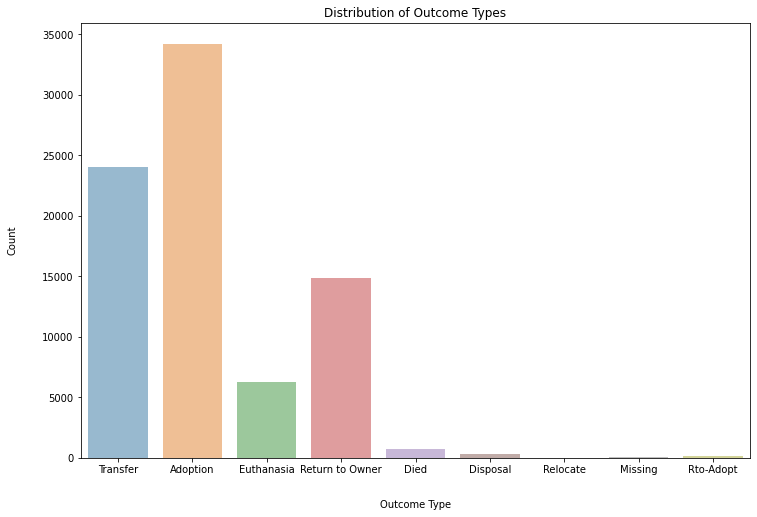

In [212]:
plt.figure(figsize=(12, 8))
sns.countplot(data=dtf, x='outcome_type', alpha=0.5)
plt.title('Distribution of Outcome Types')
plt.xlabel('Outcome Type', labelpad=25)
plt.ylabel('Count', labelpad=25)
plt.show()

We can see that most animals were adopted (almost 35,000 animals). Almost 25,000 animals were transfered (to another shelter), about 15,000 were returned to their original owners, a little bit more than 5000 were euthanized. A small number of animals have died, an even smaller number were disposed, relocated, missing or Rto-Adopted.

Overall, most animals either were adopted, transfered, returned to owner or euthanized.

***

## 2. Examining other features

### Animal Types:

Examining some of the other features, such as 'animal_type':

In [2]:
# All unique values in the 'animal_type' column
unique_animal_types = dtf['animal_type'].unique()

# Count the number of rows for each animal type
animal_type_count = {}

for animal_type in unique_animal_types:
    count = dtf['animal_type'].value_counts().get(animal_type, 0)
    animal_type_count[animal_type] = count
    
    if animal_type == 'Other' or animal_type == 'Livestock':
        print(f"Number of {animal_type} animals is {count}")
    else:
        print(f"Number of {animal_type}s is {count}")

NameError: name 'dtf' is not defined

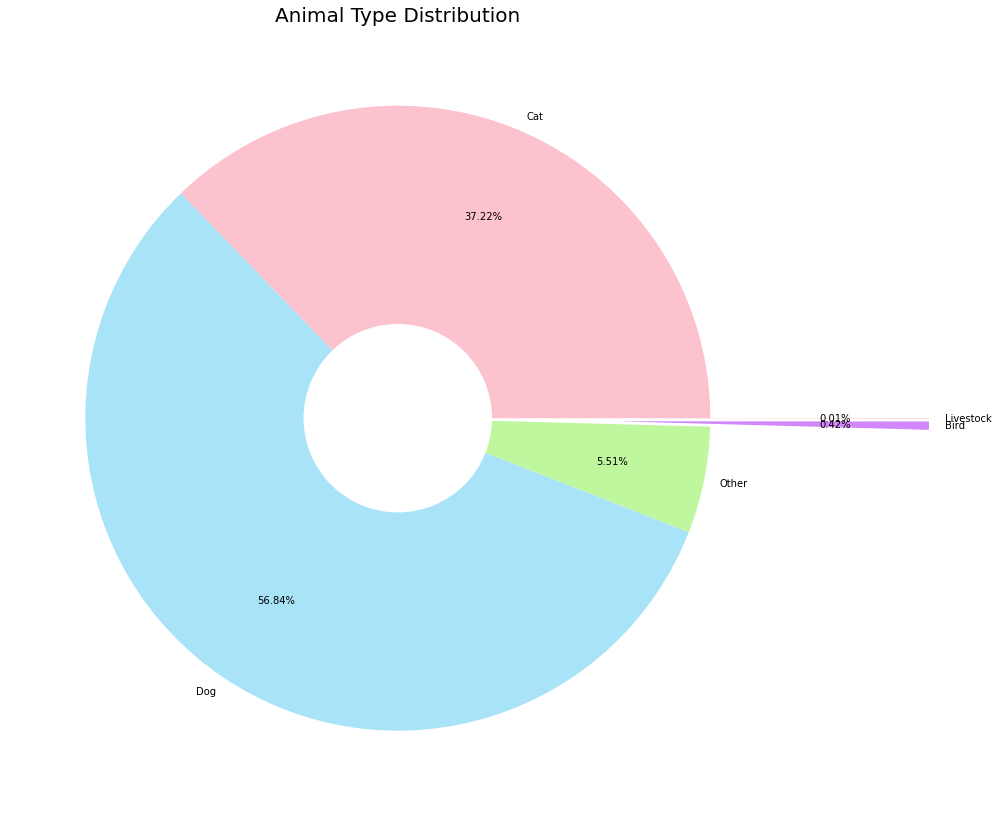

In [214]:
# Donut Plot
plt.figure(figsize=(14, 17))
animal_count = list(animal_type_count.values())

explode = (0, 0, 0, 0.7, 0.7)

plt.pie(animal_count, labels=unique_animal_types, colors=['#fcc2ce', '#a8e3f7', '#bff79e','#d186fc', '#f7524d'],
    autopct='%1.2f%%', pctdistance=0.70, labeldistance=1.05, textprops={'fontsize': 10}, explode=explode)
my_circle = plt.Circle((0, 0), 0.3, color='white')

p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Animal Type Distribution', fontsize=20)
plt.show()

Conclusions:

* Dogs are the most common animals in the shelter - 56.84% of animals in the shelter are dogs.
* The second most common animals in the shelter are cats - 37.22% of animals in the the shelter.
* The third most common animals are other kind of animals (other type of animals include small mammal such as bats, racoons and rabbits, wild animals such as bobcats and deers, reptiles such snakes and tortoises, and arachnids such tarantulas) - 5.51% of animals in the shelter.
* The fourth most common animals in the shelter are birds - 0.42% of animals in the shelter.
* The least common animals in the shelter are livestock animals (such as goats) - at just 0.01% of animals in the shelter.

### Animal Breeds:

Examining some of the other features, such as 'breed':

In [215]:
def print_breed_count(breeds, type):
    print(f"Number of different breeds of {type} in the shelter is {len(breeds.unique())}")

In [216]:
cat_breeds = dtf[dtf['animal_type'] == 'Cat']['breed']
dog_breeds = dtf[dtf['animal_type'] == 'Dog']['breed']
bird_breeds = dtf[dtf['animal_type'] == 'Bird']['breed']
other_breeds = dtf[dtf['animal_type'] == 'Other']['breed']
livestock_breeds = dtf[dtf['animal_type'] == 'Livestock']['breed']

In [217]:
print_breed_count(cat_breeds, 'cats')
print_breed_count(dog_breeds, 'dogs')
print_breed_count(bird_breeds, 'birds')
print_breed_count(other_breeds, 'other kind of animals')
print_breed_count(livestock_breeds, 'livestock animals')

Number of different breeds of cats in the shelter is 83
Number of different breeds of dogs in the shelter is 1932
Number of different breeds of birds in the shelter is 60
Number of different breeds of other kind of animals in the shelter is 98
Number of different breeds of livestock animals in the shelter is 4


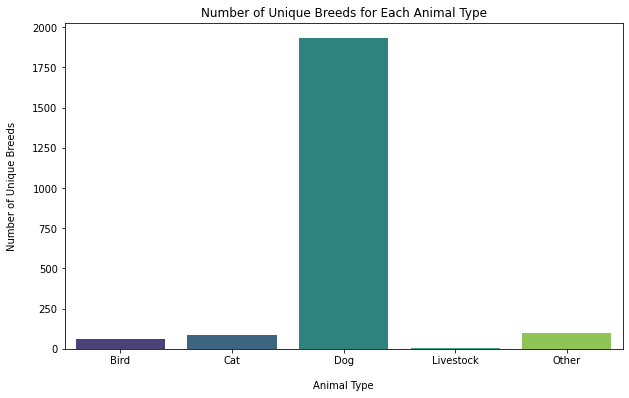

In [218]:
# Calculate the number of unique breeds for each animal type
breeds_per_animal = dtf.groupby('animal_type')['breed'].nunique().reset_index()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.barplot(data=breeds_per_animal, x='animal_type', y='breed', palette="viridis")
plt.title('Number of Unique Breeds for Each Animal Type')
plt.xlabel('Animal Type', labelpad=15)
plt.ylabel('Number of Unique Breeds', labelpad=15)
plt.show()

As listed above, number of different breeds of each animal type is:

* Cats: 83 different breeds.
* Dogs: 1932 different breeds.
* Birds: 60 different breeds.
* Other kinds of animals: 98 different breeds.
* Livestock animals: only 4 different breeds.

The plot shows the imbalanced difference between the number of different breeds of dogs compared to the number of different breeds of any other animal type in the shelter.

In [219]:
# Initialize an empty DataFrame to store skewness values
skewness_df = pd.DataFrame(columns=['Animal Type', 'Skewness of Breeds'])

# Calculate skewness for each animal type
for animal_type in ['Cat', 'Dog', 'Bird', 'Other', 'Livestock']:
    skewness = dtf[dtf['animal_type'] == animal_type]['breed'].value_counts().skew()
    skewness_df = skewness_df.append({'Animal Type': animal_type, 'Skewness of Breeds': skewness}, ignore_index=True)

# Display the DataFrame
print(skewness_df)

# Calculate overall skewness
overall_skewness = dtf['breed'].value_counts().skew()
print("\nOverall skewness of breed count across all animal types:", overall_skewness)

  Animal Type  Skewness of Breeds
0         Cat            8.922708
1         Dog           22.394997
2        Bird            6.637091
3       Other            6.220378
4   Livestock            1.539601

Overall skewness of breed count across all animal types: 37.174261520984565


This means that:

* For cats: Skewness of 8.922708 indicates that the distribution of different breeds of cats is positively skewed, meaning that there are more breeds with higher counts compared to breeds with lower counts.

* For dogs: Skewness of 22.394997 indicates a much higher positive skewness compared to cats, suggesting an even greater imbalance in the distribution of different breeds of dogs, with some breeds having much higher counts than others.

* For birds: Skewness of 6.637091 suggests a positive skewness, albeit less extreme than that of cats and dogs.

* For other kinds of animals: Skewness of 6.220378 also indicates a positive skewness, similar to birds.

* For livestock animals: Skewness of 1.539601 suggests a positive skewness, but it is the lowest among all animal types, indicating a relatively more balanced distribution of breeds compared to other animal types.

### Color of an animal:

In [220]:
def print_color_count(colors, type):
    print(f"Number of different colors of {type} in the shelter is {len(colors.unique())}")

In [221]:
cat_colors = dtf[dtf['animal_type'] == 'Cat']['color']
dog_colors = dtf[dtf['animal_type'] == 'Dog']['color']
bird_colors = dtf[dtf['animal_type'] == 'Bird']['color']
other_colors = dtf[dtf['animal_type'] == 'Other']['color']
livestock_colors = dtf[dtf['animal_type'] == 'Livestock']['color']

In [222]:
print_color_count(cat_colors, 'cats')
print_color_count(dog_colors, 'dogs')
print_color_count(bird_colors, 'birds')
print_color_count(other_colors, 'other kind of animals')
print_color_count(livestock_colors, 'livestock animals')

Number of different colors of cats in the shelter is 235
Number of different colors of dogs in the shelter is 339
Number of different colors of birds in the shelter is 72
Number of different colors of other kind of animals in the shelter is 112
Number of different colors of livestock animals in the shelter is 6


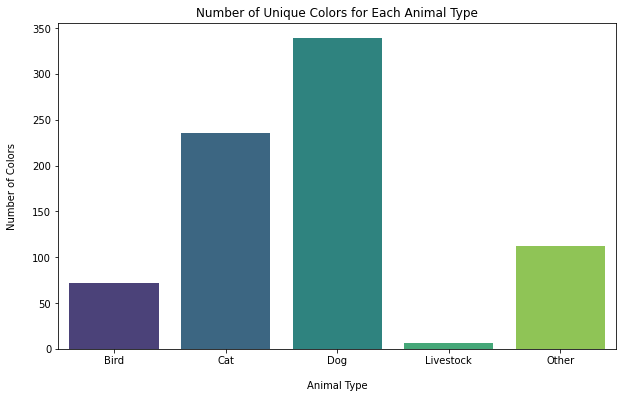

In [223]:
# Calculate the number of unique colors for each animal type
colors_per_animal = dtf.groupby('animal_type')['color'].nunique().reset_index()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.barplot(data=colors_per_animal, x='animal_type', y='color', palette="viridis")
plt.title('Number of Unique Colors for Each Animal Type')
plt.xlabel('Animal Type', labelpad=15)
plt.ylabel('Number of Colors', labelpad=15)
plt.show()

As listed above, number of different colors of each animal type is:

* Cats: 235 different colors.
* Dogs: 339 different colors.
* Birds: 72 different colors.
* Other kinds of animals: 112 different colors.
* Livestock animals: only 6 different colors.

The plot shows the some imbalanced difference between the number of different colors of dogs compared to the number of different colors of any other animal type in the shelter, though it's not as prominent. There are still a lot of different color of coats of cats' fur.

In [224]:
# Initialize an empty DataFrame to store skewness values
skewness_df = pd.DataFrame(columns=['Animal Type', 'Skewness of Colors'])

# Calculate skewness for each animal type
for animal_type in ['Cat', 'Dog', 'Bird', 'Other', 'Livestock']:
    skewness = dtf[dtf['animal_type'] == animal_type]['color'].value_counts().skew()
    skewness_df = skewness_df.append({'Animal Type': animal_type, 'Skewness of Colors': skewness}, ignore_index=True)

# Display the DataFrame
print(skewness_df)

# Calculate overall skewness
overall_skewness = dtf['color'].value_counts().skew()
print("\nOverall skewness of breed count across all animal types:", overall_skewness)

  Animal Type  Skewness of Colors
0         Cat            6.036892
1         Dog            5.915393
2        Bird            2.792843
3       Other            8.682651
4   Livestock            0.857321

Overall skewness of breed count across all animal types: 7.930317270327514


This means that:

* For cats: Skewness of 6.036892 indicates that the distribution of colors among cats is highly positively skewed. This means that there are more cats with colors towards the lower end of the range, and fewer cats with colors towards the higher end.

* For dogs: Skewness of 5.915393 suggests a similar situation as with cats. The distribution of colors among dogs is highly positively skewed, with more dogs having colors towards the lower end of the range.

* For birds: Skewness of 2.792843 indicates that the distribution of colors among birds is positively skewed, but to a lesser extent compared to cats and dogs. There might be a relatively even distribution of colors among birds, but with a slight tendency towards fewer birds having colors towards the higher end of the range.

* For other kinds of animals: Skewness of 8.682651 suggests that the distribution of colors among other kinds of animals is highly positively skewed. This means that there are significantly more animals in this category with colors towards the lower end of the range, and very few with colors towards the higher end.

* For livestock animals: Skewness of 0.857321 indicates that the distribution of colors among livestock animals is slightly positively skewed. The distribution is less skewed compared to other categories, suggesting a relatively more balanced distribution of colors among livestock animals.

***

### Viewing numeric and categorical columns

In [225]:
numeric_columns = dtf.dtypes[(dtf.dtypes=="float64") | (dtf.dtypes=="int64")].index.tolist()
categorical_columns = [c for c in dtf.columns if c not in numeric_columns and c != 'animal_id']

print(numeric_columns)
print(categorical_columns)

[]
['age_upon_outcome', 'animal_type', 'breed', 'color', 'date_of_birth', 'datetime', 'monthyear', 'name', 'outcome_subtype', 'outcome_type', 'sex_upon_outcome']


### Value Histograms for Categorical Variables (via Pandas and Matplotlib)

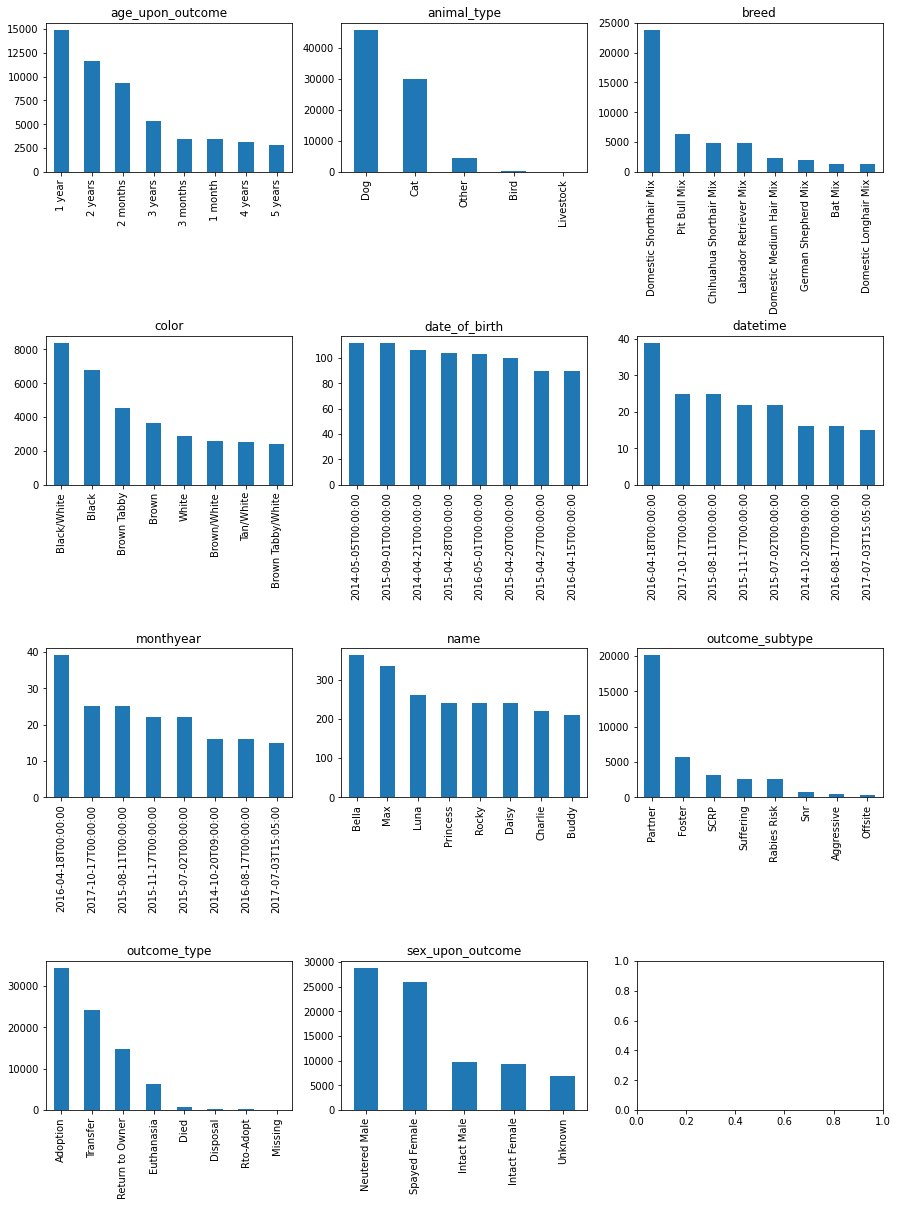

In [226]:
# Creating a histogram for each categorical attributes
n = len(categorical_columns)
cols = 3
rows = (n//3) + 1 if n%3 != 0 else 0
max_bars = 8

# Generating a figures grid:
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
fig.subplots_adjust(hspace=1.1)


for i, column in enumerate(categorical_columns):
    # Calculating the current place on the grid
    r = int(i / cols)
    c = i % cols
    
    # Creating the "value counts" for the first <max_bars> categories:
    u = min(dtf[column].nunique(), max_bars)
    vc = dtf[column].value_counts()[:u]
    
    # Plot a bar chart using Pandas
    vc.plot(kind='bar', ax=axes[r,c], title=column)

** Note that there is a histogram for some categorical columns, like 'age_upon_outcome', that will be converted (below) into numeric columns.

We can observe that:

* In terms of age_upon_outcome, the majority of animals in the dataset are young, with many being just 1 year old.

* Regarding animal_type, as previously mentioned, dogs are the most common animals in the shelter, followed by cats.

* The most common breed in the shelter is a mix of domestic shorthair cat (which isn't really a breed, more like a hybrid).

* In terms of color, the most common hair color for animals in the shelter is black and white, followed by solid black. This is unsurprising, as shelters typically have a higher population of cats and dogs, with those sporting black or black and white coats being among the least adopted.

* The most common outcome_subtype is when an animal is transferred to a partner.

* Adoption is the most frequent outcome for animals in the shelter.

* The most common sex_upon_outcome categories in the dataset are neutered males and spayed females.

***

## 3. Data processing

### Converting categorical columns into numeric columns

#### Creating helper functions

In [227]:
# Function to convert age strings to years
def convert_to_years(age_str):
    if pd.isnull(age_str):
        return None
    elif 'day' in age_str:
        return float(age_str.split()[0]) / 365
    elif 'week' in age_str:
        return float(age_str.split()[0]) / 52
    elif 'month' in age_str:
        return float(age_str.split()[0]) / 12
    elif 'year' in age_str:
        return float(age_str.split()[0])
    else:
        return None

In [228]:
# Function that converts datetimes to Unix timestamp (integer)
def convert_to_unix_timestamp(dates):
    return dates.astype(int) // 10**9

In [229]:
def convert_to_total_seconds(times):
    total_seconds = (times.dt.hour * 3600) + (times.dt.minute * 60) + (times.dt.second)
    return total_seconds

#### Converting 'age_upon_outcome' column to a numeric column

In [230]:
# Apply the function convert_to_years to the 'age_upon_outcome' column
dtf['age_upon_outcome'] = dtf['age_upon_outcome'].apply(convert_to_years)

In [231]:
dtf.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,0.038462,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1.000000,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1.000000,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9.000000,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,0.416667,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


Concluding the changes made to the dataset thus far: The 'age_upon_outcome' column has been converted into a float representing the age of animals in years.

#### Converting 'data_of_birth' column to a numeric column

In [232]:
# Converting into datetime
dates = dtf['date_of_birth']
dtf['date_of_birth'] = pd.to_datetime(dates)

In [233]:
# Apply the function convert_to_unix_timestamp to the 'age_upon_outcome' column
dtf['date_of_birth'] = convert_to_unix_timestamp(dtf['date_of_birth'])

In [234]:
dtf.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,0.038462,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,1404691200,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1.000000,A666430,Dog,Beagle Mix,White/Brown,1352160000,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1.000000,A675708,Dog,Pit Bull,Blue/White,1364688000,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9.000000,A680386,Dog,Miniature Schnauzer Mix,White,1117670400,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,0.416667,A683115,Other,Bat Mix,Brown,1389052800,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


Concluding the changes made to the dataset thus far: The 'date_of_birth' column has been converted into Unix timestamp format.

#### Converting 'datatime' and 'monthyear' columns into numeric columns

In [235]:
column1 = dtf['datetime']
column2 = dtf['monthyear']

# Check if the two columns are equal
are_equal = (column1 == column2).all()

# Print the result
print(f"Columns are equal: {are_equal}")

Columns are equal: True



Transforming the column 'datetime' into two columns - 'outcome_date' (containing the date of outcome) and 'outcome_hour' (containing the hour of outcome):

In [236]:
# Rename the column 'datetime' as 'outcome_date'
dtf.rename(columns={'datetime': 'outcome_date'}, inplace=True)

In [237]:
# Creating a new column 'outcome_hour'
# Copy the column 'outcome_date' into a new column 'outcome_hour'
dtf['outcome_hour'] = dtf['outcome_date']

# Rearranging the columns in dtf
column_order = ['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'color', 'date_of_birth', 'outcome_date',
                'outcome_hour', 'monthyear', 'name', 'outcome_subtype', 'outcome_type', 'sex_upon_outcome']
dtf = dtf[column_order]

# Converting 'outcome_date' into datetime
dates = dtf['outcome_date']
dtf['outcome_date'] = pd.to_datetime(dates).dt.date
dtf['outcome_date'] = pd.to_datetime(dtf['outcome_date'])

# Converting 'outcome_hour' into datetime
dates = dtf['outcome_hour']
dtf['outcome_hour'] = pd.to_datetime(dates).dt.time
dtf['outcome_hour'] = pd.to_datetime(dtf['outcome_hour'], format='%H:%M:%S')

Transforming the column 'monthyear' into two columns - 'outcome_year' (containing the year of outcome) and 'outcome_month' (containing the month of outcome):

In [238]:
# Rename the column 'monthyear' as 'outcome_year'
dtf.rename(columns={'monthyear': 'outcome_year'}, inplace=True)

In [239]:
# Creating a new column 'outcome_month'
# Copy the column 'outcome_year' into a new column 'outcome_month'
dtf['outcome_month'] = dtf['outcome_year']

# Rearranging the columns in dtf
column_order = ['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'color', 'date_of_birth', 'outcome_date',
                'outcome_hour', 'outcome_year', 'outcome_month', 'name', 'outcome_subtype', 'outcome_type', 'sex_upon_outcome']
dtf = dtf[column_order]

# Converting 'outcome_year' into a year
dates = dtf['outcome_year']
dtf['outcome_year'] = pd.to_datetime(dates).dt.year

# Converting 'outcome_month' into datetime
dates = dtf['outcome_month']
dtf['outcome_month'] = pd.to_datetime(dates).dt.month

In [240]:
# Apply the function convert_to_unix_timestamp to the 'outcome_date' column
dtf['outcome_date'] = convert_to_unix_timestamp(dtf['outcome_date'])

In [241]:
# Apply the function convert_to_total_seconds to the 'outcome_hour' column
dtf['outcome_hour'] = convert_to_total_seconds(dtf['outcome_hour'])

In [242]:
dtf.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,outcome_date,outcome_hour,outcome_year,outcome_month,name,outcome_subtype,outcome_type,sex_upon_outcome
0,0.038462,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,1404691200,1405987200,57840,2014,7,NaN,Partner,Transfer,Intact Male
1,1.000000,A666430,Dog,Beagle Mix,White/Brown,1352160000,1383782400,42420,2013,11,Lucy,Partner,Transfer,Spayed Female
2,1.000000,A675708,Dog,Pit Bull,Blue/White,1364688000,1401753600,51600,2014,6,*Johnny,NaN,Adoption,Neutered Male
3,9.000000,A680386,Dog,Miniature Schnauzer Mix,White,1117670400,1402790400,57000,2014,6,Monday,Partner,Transfer,Neutered Male
4,0.416667,A683115,Other,Bat Mix,Brown,1389052800,1404691200,50640,2014,7,NaN,Rabies Risk,Euthanasia,Unknown


Concluding the changes made to the dataset thus far:

* The 'datetime' column was split into two columns: 'outcome_date' and 'outcome_hour'.

* The 'monthyear' column was split into two columns: 'outcome_year' and 'outcome_month'.

* The 'outcome_date' column initially included the date of the outcome and was later converted into Unix timestamp format.

* The 'outcome_hour' column initially included the hour of the outcome and was later converted into the total sum of seconds.

* The 'outcome_year' column now contains the year of the outcome.

* The 'outcome_month' column now contains the month of the outcome.

***

## 4. Viewing numeric columns - After change

In [243]:
numeric_columns = dtf.dtypes[(dtf.dtypes=="float64") | (dtf.dtypes=="int64")].index.tolist()
print(numeric_columns)

['age_upon_outcome', 'date_of_birth', 'outcome_date', 'outcome_hour', 'outcome_year', 'outcome_month']


### Value Histograms for Numeric Variables (via Pandas and Matplotlib)

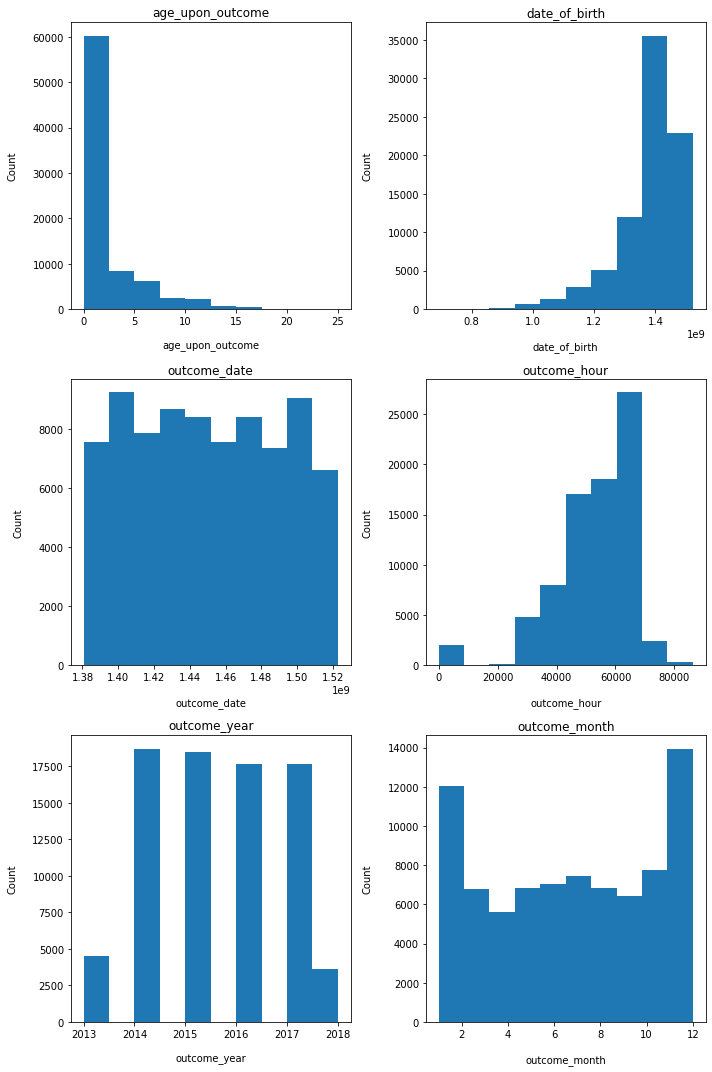

In [244]:
# Creating a histogram for each numeric attributes
n = len(numeric_columns)

# Generating a figure grid
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
fig.subplots_adjust(hspace=0.5)
axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    axes[i].hist(dtf[column])
    axes[i].set_title(column)
    axes[i].set_xlabel(column, labelpad=15)
    axes[i].set_ylabel('Count', labelpad=15)

plt.tight_layout()
plt.show()

We can observe that:

* In the 'age_upon_outcome' column, the majority of animals in the dataset are quite young, with ages ranging from a few days or weeks old to under 1 year old, and some aged 2 to 2.5 years.

* The 'outcome_year' column indicates that most of the data in the dataset is from 2014, although the years 2014 to 2017 are fairly evenly distributed.

* The 'outcome_month' column shows that December is the most common month in the dataset.

In [245]:
dtf.describe()

,age_upon_outcome,date_of_birth,outcome_date,outcome_hour,outcome_year,outcome_month
count,80673.000000,8.068100e+04,8.068100e+04,80681.000000,80681.000000,80681.000000
mean,2.143631,1.379450e+09,1.450394e+09,53141.204497,2015.448210,6.684164
std,2.897856,1.011316e+08,4.043045e+07,13752.779360,1.324345,3.420613
min,0.000000,6.924096e+08,1.380586e+09,0.000000,2013.000000,1.000000
25%,0.250000,1.347581e+09,1.414454e+09,45660.000000,2014.000000,4.000000
50%,1.000000,1.401149e+09,1.448842e+09,55560.000000,2015.000000,7.000000
75%,3.000000,1.445299e+09,1.485475e+09,63420.000000,2017.000000,10.000000
max,25.000000,1.522368e+09,1.522714e+09,86280.000000,2018.000000,12.000000


We can observe that, for instance, the average age of animals in the dataset (age_upon_outcome) is around 2 years old. Additionally, the minimum age of an animal is 0 years old, and the maximum age is 25 years old.

***

## 5. Examining correlations to the target feature

#### One hot enconding

In [247]:
dtf_encoded = pd.get_dummies(dtf, columns=['outcome_type', 'animal_type'], prefix=['outcome_type', 'animal_type'])

In [249]:
outcome_type_columns = [col for col in dtf_encoded.columns if 'outcome_type' in col]
print(outcome_type_columns)

['outcome_type_Adoption', 'outcome_type_Died', 'outcome_type_Disposal', 'outcome_type_Euthanasia', 'outcome_type_Missing', 'outcome_type_Relocate', 'outcome_type_Return to Owner', 'outcome_type_Rto-Adopt', 'outcome_type_Transfer']


In [250]:
animal_type_columns = [col for col in dtf_encoded.columns if 'animal_type' in col]
print(animal_type_columns)

['animal_type_Bird', 'animal_type_Cat', 'animal_type_Dog', 'animal_type_Livestock', 'animal_type_Other']


***

#### Correlations of numeric columns (using the encoded data frame):

In [251]:
dtf_corr = dtf_encoded.corr(method="pearson").loc[outcome_type_columns]

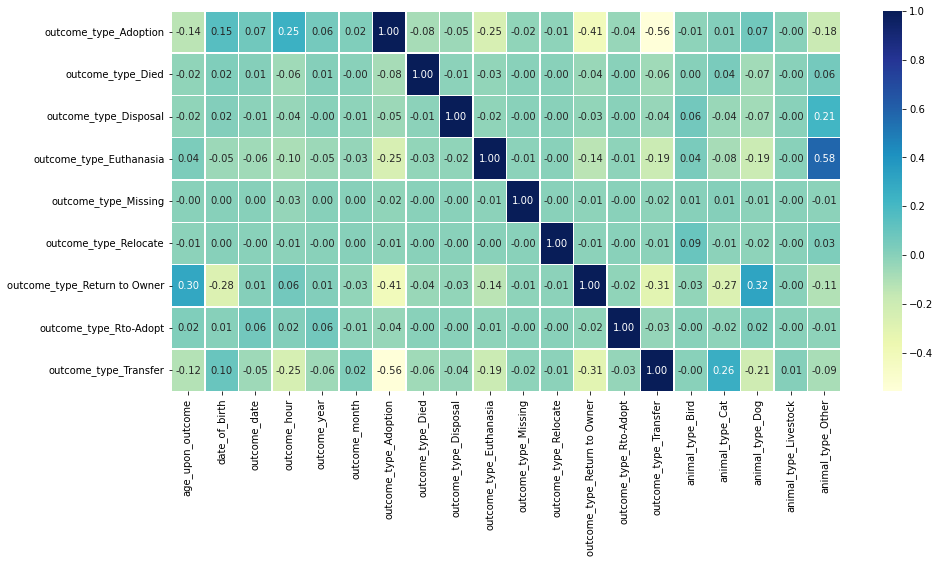

In [252]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(dtf_corr, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5, ax=ax)
plt.show()

As seen above, the correlation between a feature with itself is the highest (1.00 - colored as dark blue).

There's a high correlation between other animal types and authanasia as an outcome (many animals, such as bats and racoons, get euthanized) - correlation of 0.58

A slightly lower but still noteworthy correlation is evident between dogs and the outcome of being returned to their owners (animal_type_Dog, outcome_type_Return to Owner) - correlation of 0.32

Similarly, for cats, there is a correlation between cats that are being transfered to other shelters (animal_type_Cat, outcome_type_Transfer) - correlation of 0.26. There is also an oposite correlation between cats that are being returned to their owners - cats are less likely to be returned to their owner, once they were surrendered by their owners to the shelter (animal_type_Cat, outcome_type_Return to Owner) - correlation of -0.27.

There is a correlation between the age of the animal and their chances to be reunited with their owners (age_upon_outcome, outcome_type_Return to Owner) - correlation of 0.30.

There is also a correlation between the hour of the day and adoption (outcome_houe, outcome_type_Adoption) - correlation of 0.30. Perhaps the shelter has regular adoption hours.

Some of the features lack any correlation (correlation value of 0.00, or close to 0.00) according to the plot above. For example, there is no correlation between livestock animals who get adopted (animal_type_Livestock, outcome_type_Adoption) - correlation of 0.00.

***

### Visualzing relevant feature-pair relations:

#### Relations with 'age_upon_outcome' feature:

(Using the encoded data frame).

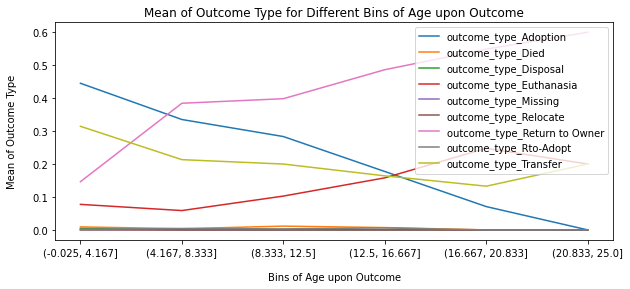

In [262]:
# Create bins for 'age_upon_outcome'
bins = pd.cut(dtf_encoded['age_upon_outcome'], 6)

# Group by bins and calculate the mean for each group for 'outcome_type_columns'
grouped_means = dtf_encoded.groupby(bins)[outcome_type_columns].mean()

# Plot the line plot
fig, ax = plt.subplots(figsize=(10, 4))
grouped_means.plot(kind='line', ax=ax)

# Adjust labels and title as needed
ax.set_xlabel('Bins of Age upon Outcome', labelpad=15)
ax.set_ylabel('Mean of Outcome Type', labelpad=15)
ax.set_title('Mean of Outcome Type for Different Bins of Age upon Outcome')

plt.show()

The x-axis is represented by bins, each bin is a range of ages of animals in the shelter (note that -0.025 doesn't represent an actual age. Since all the graphs start from the age of 0, and not from -0.025, then there's no problem).

We can see that younger animals are more likely to get adopted, while older animal don't, as indicated by the blue graph. For instance, animals aged 0-4 years have a higher chance to get adopted (mean of outcome_type_Adoption is approximately 0.45), while older animals, ranging from 16 to 20 years, have a substantially lower adoption rate (mean of outcome_type_Adoption is approximately 0.1).

The red graph illustrates that younger animals face a lower likelihood of euthanasia compared to older animals.

The pink graph illustrates that younger animals are less likely to be returned to owners compared to older animals.

Outliers - different outcomes depending on the age of an animal in the shelter:

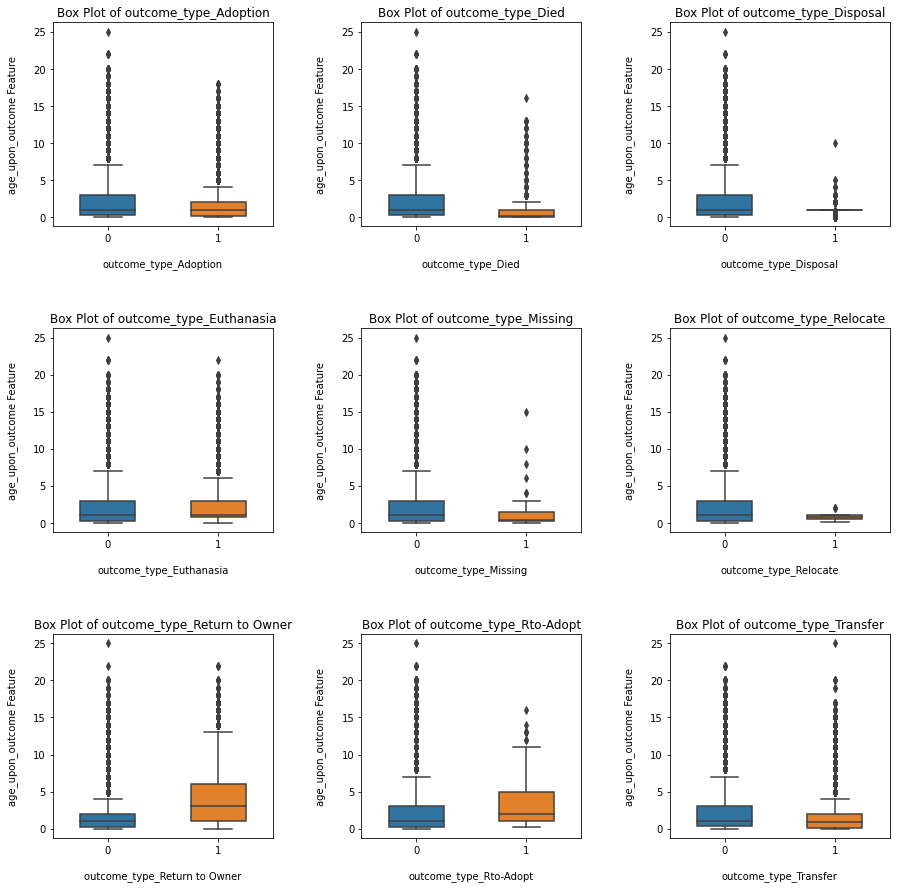

In [281]:
# Create individual box plots for each outcome type
# Create subplots with a grid layout
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5, wspace=0.4)
axes = axes.flatten()

# Iterate through each 'outcome_type' column and create a box plot on a subplot
for i, column in enumerate(outcome_type_columns):
    sns.boxplot(x=dtf_encoded[column], y=dtf_encoded['age_upon_outcome'], width=0.5, ax=axes[i])
    axes[i].set_title(f'Box Plot of {column}')
    axes[i].set_xlabel(column, labelpad=15)
    axes[i].set_ylabel('age_upon_outcome Feature', labelpad=15)

plt.show()

The "1" values (on the x-axis) represent all animals for which the listed outcome occurred (while "0" indicates that this outcome did not occur for the animal).

Addressing only the values where outcome_type_X == 1:
* We observe that the majority of animals that were adopted (outcome_type_Addoption) are young. There are few instances in the dataset of animals ranging from over 5 years old to 25 years old being adopted.

* Most animals that died (outcome_type_Died) were very young (under 5 years old). There are a few instances in the data of animals that died slightly younger than 5 years old or slightly older, and there is a single instance of an animal that died at the age of 15 or 16.

* There were not many animals that were disposed (outcome_type_Disposal), and most of them were under 5 years old. One animal was disposed of at an age older than 10.

* The majority of animals that were euthanized (outcome_type_Euthanasia) are young (younger than 5 years old). There are a few instances of animals older than 5, with the oldest being slightly older than 20 years old.

* Few animals went missing (outcome_type_Missing), but those that did were typically younger than 5 years old. There are only a few instances of missing animals older than 5, with the oldest being 15 years old.

* Barely any animals were relocated (outcome_type_Relocate), but those that were tended to be very young (under the age of 5).

* Most animals returned to their previous owners (outcome_type_Return to Owner) are young, with only a few instances of older animals (the oldest being around 20 years old).

* The majority of animals that were returned to be rto-adopted (outcome_type_Rto-Adopt) are under 5 years old, with only a few instances of older animals (the oldest being 15 or 16 years old).

* There were not many animals transferred (outcome_type_Transfer), but those that were tended to be younger than 5 years old, except for a few instances ranging from slightly younger than 5 years old to 25 years old.

#### Relations with 'animal_type' feature:

Comparing the outcome of animals by their type (focusing on the main four possible outcomes - adoption, euthnasia, return to owner and transfer).

In [264]:
# Filter the DataFrame for the desired animal types and outcome types
filtered_df = dtf[(dtf['animal_type'].isin(['Cat', 'Dog', 'Bird', 'Other', 'Livestock'])) & 
                          (dtf['outcome_type'].isin(['Adoption', 'Euthanasia', 'Return to Owner', 'Transfer']))]

By 'animal_type' count:

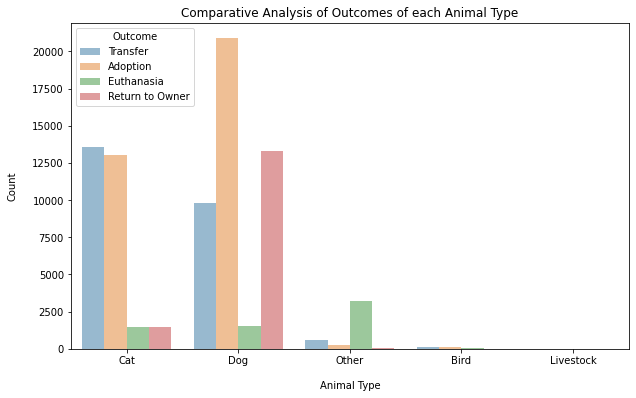

In [265]:
# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_df, x='animal_type', hue='outcome_type', alpha=0.5)
plt.title('Comparative Analysis of Outcomes of each Animal Type')
plt.xlabel('Animal Type', labelpad=15)
plt.ylabel('Count', labelpad=15)
plt.legend(title='Outcome')
plt.show()

From the graph, we can observe that the majority of cats have either been transferred to other shelters or adopted, while most dogs were adopted. Additionally, some dogs were returned to their owners, and a few were transferred to other shelters.
The outcomes of other types of animals, and of birds and livestock, aren't prominent in the dataset and therefore aren't shown here.

By proportion of each 'animal_type':

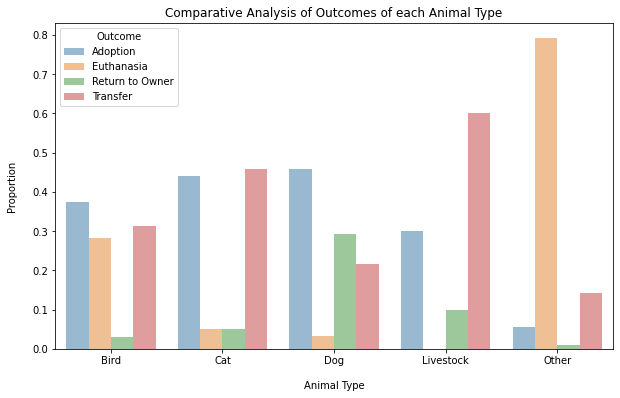

In [266]:
# Calculate the proportions
proportions = filtered_df.groupby(['animal_type', 'outcome_type']).size() / filtered_df.groupby('animal_type').size()

# Reset index for easier plotting
proportions = proportions.reset_index(name='proportion')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=proportions, x='animal_type', y='proportion', hue='outcome_type', alpha=0.5)
plt.title('Comparative Analysis of Outcomes of each Animal Type')
plt.xlabel('Animal Type', labelpad=15)
plt.ylabel('Proportion', labelpad=15)
plt.legend(title='Outcome')
plt.show()

Now that the outcomes of animals in the shelter are displayed proportionally to the number of animals for each type, we can observe that, as mentioned earlier, the majority of cats have either been transferred to other shelters or adopted, while most dogs were adopted (and some dogs were returned to their owners, and a few were transferred to other shelters), additionally, the majority of other types of animals were euthanized (and they are the most euthanized animals of all five animal groups in the shelter), the majority of birds were adopted (and some were transfered or euthanized), and the majority of livestock animals were transfered (and some were adopted).

#### Relations with 'color' feature:

Comparing the outcome of animals by their color (focusing on the main four possible outcomes - adoption, euthnasia, return to owner and transfer).

In [267]:
def get_top_k_colors(colors, k):
    color_count = len(colors.unique())
    num = min(k, color_count)
    return colors.value_counts().head(num)

In [268]:
# Filter the DataFrame for the desired outcome types
filtered_df = dtf[dtf['outcome_type'].isin(['Adoption', 'Euthanasia', 'Return to Owner', 'Transfer'])]

# Group by animal type and get the top colors for each
top_colors_per_animal_type = filtered_df.groupby('animal_type')['color'].apply(lambda x: get_top_k_colors(x, k=5))

# Combine the indices of the top colors per animal type
top_k_colors_per_animal_type = top_colors_per_animal_type.index.get_level_values(1)

# Filter the DataFrame for the top k colors per animal type
filtered_df = filtered_df[filtered_df['color'].isin(top_k_colors_per_animal_type)]

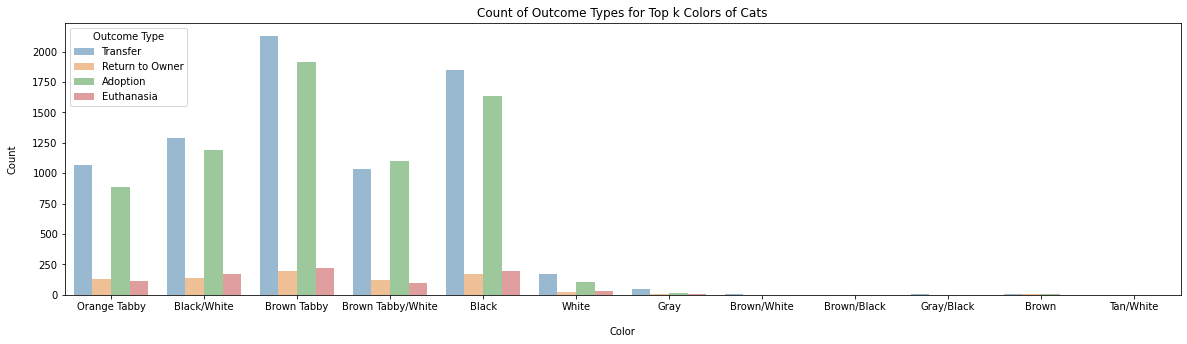

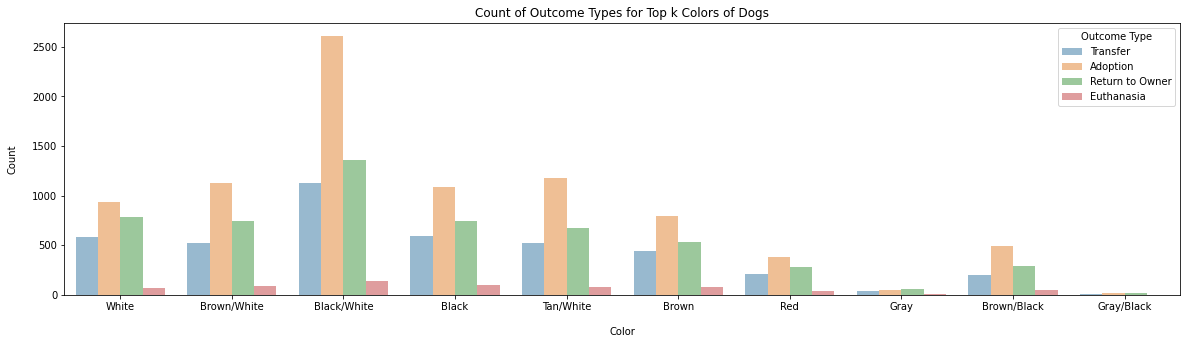

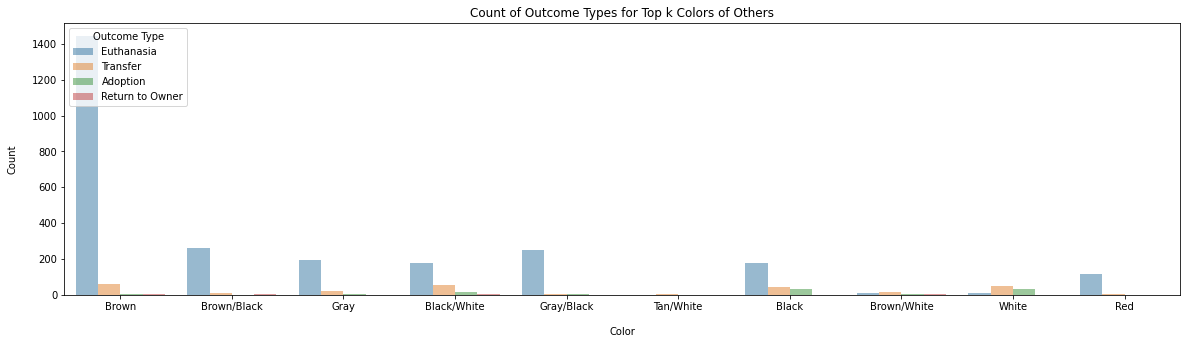

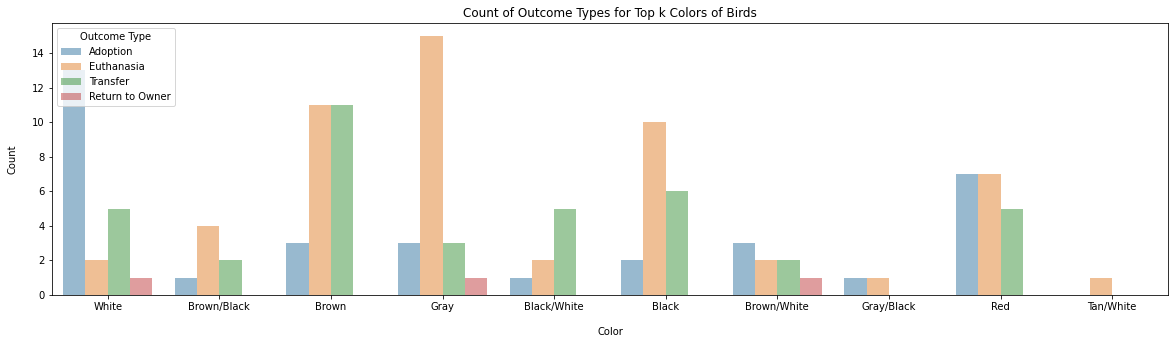

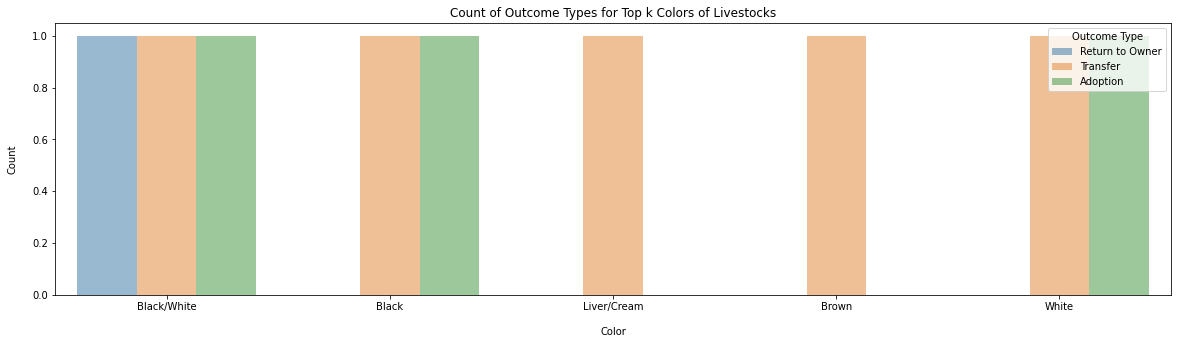

In [269]:
# Create a countplot for each animal type
for animal_type in filtered_df['animal_type'].unique():
    plt.figure(figsize=(20, 5))
    sns.countplot(data=filtered_df[filtered_df['animal_type'] == animal_type], x='color', hue='outcome_type', alpha=0.5)
    plt.title(f'Count of Outcome Types for Top k Colors of {animal_type}s')
    plt.xlabel('Color', labelpad=15)
    plt.ylabel('Count', labelpad=15)
    plt.legend(title='Outcome Type')
    plt.show()

We can conclude some insights from the graphs:

1. For cats:

* The majority of cats were either transferred or adopted, with most being transferred.
* Brown tabby cats are the most common in the shelter, and the majority of them were either transferred or adopted (most of them were transfered).
* Black cats rank as the second most common in the shelter, with a similar outcome of being mostly transferred or adopte (most of them were transfered).
* Other common cat types include ginger (orange tabby), tuxedo (black and white), and cats with a mix of white and brown tabby fur, with the majority also being transferred or adopted (most of them were transfered).
* Cats with other hair colors were less common.

2. For dogs:

* The majority of dogs were adopted, with some being returned to their owners and a few transferred to other shelters.
* Dogs with black and white fur are the most common in the shelter, and the majority of them were adopted (and some dogs were returned to their owners, and a few were transferred to other shelters).
* Other common dog fur include white/brown and white/black/tan(or white)/brown.

3. For other kinds of animals:

* The majority of them were euthanized.
* Most of them were brown.

4. For birds:

* The data isn't consistent (however, there isn't much data about birds) - birds of different colors had different outcomes.
* Gray birds were the most common in the shelter, with the majority being euthanized.
* White birds ranked as the second most common, and the majority of them were adopted.
* Brown birds were the third most common, with the majority either euthanized or transferred.
* Black birds were the fourth most common, and the majority were euthanized.
* Red birds were the fifth most common, with the majority either adopted or euthanized, and some transferred (and some were transferred).


5. For livestock:

* Data is also inconsistent, with limited information available for livestock.
* Most livestock in the shelter are black and white (3 animals). One of them was returned to previous owner, the second was transfered, and the third was euthanized.

Overall, we can see that there's consistency in outcomes for the majority of animals in the dataset, specifically cats and dogs (which are most common animals in dataset).

## 6. Creating a Baseline Model

### Training the basic model and predicting

In [270]:
# Initialize the label encoder
encoder = LabelEncoder()

In [271]:
# Drop 'animal_id' column from the dataframe
dtf_model = dtf.drop('animal_id', axis=1)

# List of categorical columns to encode
categorical_columns = ['breed', 'color', 'name', 'outcome_subtype', 'sex_upon_outcome', 'outcome_type', 'animal_type']

# Encode categorical columns
for column in categorical_columns:
    dtf_model[column] = encoder.fit_transform(dtf_model[column])

In [272]:
# Separate features and target variable
X = dtf_model.drop('outcome_type', axis=1)  # Features
y = dtf_model['outcome_type']  # Target variable

# split the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [273]:
# Initialize the model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [274]:
# Fit the model on the training data
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [275]:
# Predict on the test data
y_pred = model.predict(X_test)

### Evaluating the model

In [277]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 89.23%


In [278]:
# Perform 10-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=10)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.87991077 0.88249876 0.85647    0.88063956 0.89762023 0.90195835
 0.90307387 0.89638076 0.89786812 0.90183441]
Mean cross-validation score: 0.8898254844971539


Note that the mean cross-validation score in 88.98%, which is close to the accuracy that was calculated (89.23%).
The model utilized a basic LabelEncoder to encode categorical data, and since the data has a lot of null values and was barely proccessed, then there might be some improvement in accuracy in future predictions.

In [283]:
print("R2 Score:", r2_score(y_test, y_pred))

R2 Score: 0.6978322754171836


a score of around 0.6978 suggests that your model explains about 69.78% of the variance in the target variable (outcome_type), which is a decent result.

In [285]:
print("Mean Absolute Perc Error (Σ(|y - pred|/y)/n):","{:,.3f}".format(mean_absolute_percentage_error(y_test, y_pred)))
print("Mean Absolute Error (Σ|y - pred|/n):", "{:,.0f}".format(mean_absolute_error(y_test, y_pred)))
print("Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)):", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

# Residuals
residuals = y_test - y_pred
max_error = residuals.abs().max()
max_idx = residuals[residuals==max_error].index[0]
print("Max Error:", "{:,.0f}".format(max_error))

Mean Absolute Perc Error (Σ(|y - pred|/y)/n): 1,303,328,391,883,263.000
Mean Absolute Error (Σ|y - pred|/n): 1
Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)): 2
Max Error: 7


In [291]:
# Calculate relative residuals by taking the absolute value of the residuals divided by the true target values (y_test)
rel_res = residuals / y_test
rel_res = rel_res.abs()

How many time did our model achieve low estimation error (error less than 5%)?:

In [295]:
# Calculate the number of times the model achieved low estimation error (error less than 5%)
low_error_count = len(rel_res[rel_res < 0.05])
proportion_low_error = low_error_count / len(rel_res)

print(proportion_low_error)

0.5182499845076532


 Approximately 51.82% of the time, the model achieved a low estimation error (less than 5%). This indicates that the model's predictions were within 5% of the true values about half of the time.

How about more than 20%?

In [296]:
# Calculate the proportion of times the model achieved high estimation error (error more than 20%)
high_error_count = len(rel_res[rel_res > 0.2])
proportion_high_error = high_error_count / len(rel_res)

print(proportion_high_error)

0.10708310094813163


Approximately 10.71% of the time, the model achieved a high estimation error (more than 20%). This indicates that the model's predictions were off by more than 20% of the true values about 10.71% of the time.